In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from matplotlib import colors,colorbar
%matplotlib inline
import csv 
import math
from math import radians, cos, sin, asin, sqrt
from scipy import stats
import math
import cPickle 

/Users/David/Desktop/Jobs/GlobalFishingWatch/github/vessel-maps/utilities/pipa_paper/venv/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
import bq  
client = bq.Client.Get()

In [3]:
def Query(q):
    t0 = time.time()
    answer = client.ReadTableRows(client.Query(q)['configuration']['query']['destinationTable'])
    print 'Query time: ' + str(time.time() - t0) + ' seconds.'
    return answer

In [4]:
q = '''
SELECT 
  integer(FLOOR(lat)) lat_bin,
  integer(FLOOR(lon)) lon_bin,
  count(*) gap_starts
FROM [scratch_david_gapanalysis.2015_24hr_gaps_scored] 
where mmsi not in (412437961,412437962,412420502,412420503,412420576,412420574,412420789,412420871,
      900025357,900025393,413322650,414203586,412211196,412440255,412440256,412440257,412440258,412440259,
      412440261,150200162,412440077,412440078,412420805,412420421,412440377,412425706,412447093,412211691,
      412420276,412420917,411041815, 525018188, 412420276,412420561,533180156)
group by lat_bin, lon_bin
'''

all_gaps_nofilter = Query(q)

Waiting on bqjob_r4b2d54142559a7cb_00000154f1aff8c5_1 ... (0s) Current status: DONE   
Query time: 14.9461789131 seconds.


In [135]:
# first calculate a raster of vessel locations from the query
cellsize = 1
num_lons = 360/cellsize
num_lats = 180/cellsize

gaps_nofilter = np.zeros(shape=(num_lats,num_lons)) 
for row in all_gaps_nofilter:
    lat = int(row[0])
    lon = int(row[1])
    if lat<90 and lat>-90 and lon>-180 and lon<180:
        lat_index = (lat+90)/(cellsize)
        lon_index = (lon+180)/(cellsize)
        gaps_nofilter[lat_index][lon_index] += int(row[2]) # one vessel 

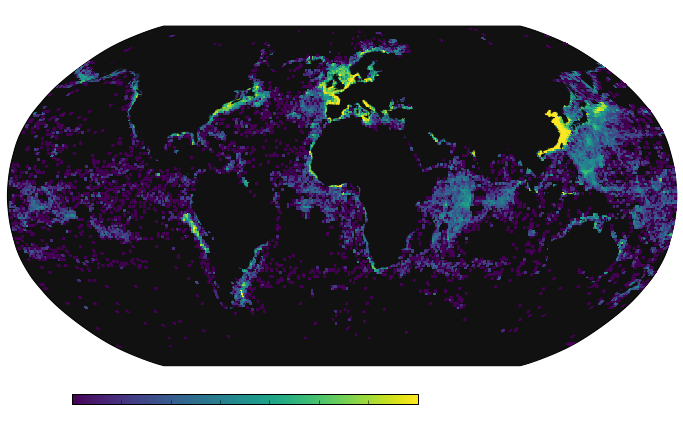

In [137]:
raster = np.copy(gaps_nofilter)
title="Number of 24+ hour gaps in AIS in 2015, No Filter"
colorbar_label="Gaps per 1 Degree Square"
maximum=500
minimum=1
scale_type ="log"
cutoff=0
savefig=1 
png="24hrgaps_nofilter.png"
continent_color = '#111111'
            
plt.clf()
plt.rcParams["figure.figsize"] = [12,7]
firstlat = 90-cutoff
lastlat = -90+cutoff
firstlon = -180
lastlon = 180
scale = cellsize
truncated_grid = raster[cutoff/cellsize:(180/cellsize)-cutoff/cellsize][:]

numlats = int((firstlat-lastlat)/scale+.5)
numlons = int((lastlon-firstlon)/scale+.5)
lat_boxes = np.linspace(lastlat,firstlat,num=numlats,endpoint=False)
lon_boxes = np.linspace(firstlon,lastlon,num=numlons,endpoint=False)
fig = plt.figure()
m = Basemap(llcrnrlat=lastlat, urcrnrlat=firstlat,
          llcrnrlon=lastlon, urcrnrlon=firstlon, lat_ts=0, projection='robin',resolution="h", lon_0=0)
m.drawmapboundary(fill_color='#111111')
# m.drawcoastlines(linewidth=.2)
m.fillcontinents(continent_color,lake_color=continent_color)#, lake_color, ax, zorder, alpha)
x = np.linspace(-180, 180, 360/cellsize)
y = np.linspace(lastlat, firstlat, (firstlat-lastlat)/cellsize)
x, y = np.meshgrid(x, y)
converted_x, converted_y = m(x, y)
from matplotlib import colors,colorbar
if scale_type == 'log':
    norm = colors.LogNorm(vmin=minimum, vmax=maximum)
else:
    norm = colors.Normalize(vmin=minimum, vmax=maximum)

m.pcolormesh(converted_x, converted_y, truncated_grid, norm=norm, vmin=minimum, vmax=maximum, cmap = plt.get_cmap('viridis'))
if title == None:
    title = "A Raster of Some Sorts"
plt.title(title, color = "#FFFFFF", fontsize=18)

ax = fig.add_axes([0.2, 0.1, 0.4, 0.02]) 
if scale_type == "log":
    lvls = np.logspace(np.log10(minimum),np.log10(maximum),num=8)
    cb = colorbar.ColorbarBase(ax,norm = norm, orientation='horizontal', ticks=lvls, cmap = plt.get_cmap('viridis'))
    the_labels = []
    for l in lvls:
        if l>=1:
            l = int(l)
        the_labels.append(l)
    cb.ax.set_xticklabels(the_labels, fontsize=10, color = "#FFFFFF")
else:
    cb = colorbar.ColorbarBase(ax,norm = norm, orientation='horizontal', cmap = plt.get_cmap('viridis'))

cb.set_label(colorbar_label,labelpad=-40, y=0.45, color = "#FFFFFF")
ax.text(1.7, -0.5, 'Data Source: Orbcomm\nMap by Global Fishing Watch',
        verticalalignment='bottom', horizontalalignment='right',
        transform=ax.transAxes, color='#FFFFFF', fontsize=6)
if savefig:
    plt.savefig(png,bbox_inches='tight',dpi=300,transparent=True,pad_inches=.1, facecolor="#000000")
plt.show()

In [138]:
q = '''    
    SELECT 
    integer(floor(lat)) lat_bin,
    integer(floor(lon)) lon_bin,
    (sum(last_hours) + sum(next_hours))/2 vessel_hours,
    avg(distance_from_shore) distance_from_shore
    FROM [scratch_global_fishing_raster.2015_with_score_and_hours]
    where 
      lat > -80 and lat < 90 and lat != 0 
        and not (lon > -7.63 and lat>7.49 and lon < 30.76 and lat < 29.57)
        and not (lon > -7.63 and lat>29.34 and lon < 11.21 and lat < 32.93)
        and not (lon > -0.66 and lat>32.79 and lon < 9.8 and lat < 35.41)
        and not (lon > 13.16 and lat>-3.07 and lon < 29.9 and lat < 6.49)
        and not (lon > -121.0 and lat>47.7 and lon < -109.5 and lat < 52.2)
        and not (lon > 33.09 and lat>54.29 and lon < 42.54 and lat < 59.87)
        and not (lon > 56.6 and lat>41.6 and lon < 116.9 and lat < 65.4)
        and not (lon > 56.6 and lat>29.61 and lon < 77.17 and lat < 45.27)
        and not (lon > 103.29 and lat>11.63 and lon < 107.47 and lat < 15.22)
        and not (lon > 94.86 and lat>19.41 and lon < 105.12 and lat < 24.63)
        and not (lon > 113.77 and lat>-0.88 and lon < 116.88 and lat < 3.44)
        and not (lon > 19.24 and lat>-31.25 and lon < 28.57 and lat < 3.31)
        and not (lon > 88.2 and lat>60.8 and lon < 149.46 and lat < 70.45)
        and not (lon > 100.5 and lat>43.9 and lon < 132.7 and lat < 70.2)
        and not (lon > 38.01 and lat>26.49 and lon < 47.15 and lat < 34.69)
        and not (lon > 20.57 and lat>19.06 and lon < 24.43 and lat < 31.52)
        and not (lon > 11.84 and lat>50.32 and lon < 17.12 and lat < 51.82)
        and not (lon > -0.9 and lat>41.77 and lon < 1.87 and lat < 43.68)
        and not (lon > 8.72 and lat>44.73 and lon < 10.9 and lat < 48.67)
        and not (lon > -51.33 and lat>-22.53 and lon < -44.17 and lat < -18.77)
        and not (lon > -86.0394 and lat>41.8205 and lon < -84.1388 and lat < 44.2845)
        and not (lon > -52.46 and lat>-28.91 and lon < -50.16 and lat < -26.02)

      and lon > -180 and lon < 180
      and  mmsi IN (
        SELECT
          mmsi
        FROM
          [scratch_global_fishing_raster.2015_mmsi_pointcounts]
        WHERE
          num_points >= 1000)
      and mmsi not in (412437961,412437962,412420502,412420503,412420576,412420574,412420789,412420871,
      900025357,900025393,413322650,414203586,412211196,412440255,412440256,412440257,412440258,412440259,
      412440261,150200162,412440077,412440078,412420805,412420421,412440377,412425706,412447093,412211691,
      412420276,412420917,411041815, 525018188, 412420276,412420561,533180156)
      and mmsi in (select mmsi from [scratch_bjorn.2015_combined_fishing])
    group by lat_bin, lon_bin
    '''
fishing_vessel_density_unfiltered = Query(q)

Waiting on bqjob_r7437796c760e6332_00000154d9368c0a_15 ... (15s) Current status: DONE   
Query time: 23.599476099 seconds.


In [139]:
# first calculate a raster of vessel locations from the query
cellsize = 1
num_lons = 360/cellsize
num_lats = 180/cellsize

fishing_grid_unfiltered = np.zeros(shape=(num_lats,num_lons)) 
for row in fishing_vessel_density_unfiltered:
    lat = int(row[0])
    lon = int(row[1])
    if lat<90 and lat>-90 and lon>-180 and lon<180:
        lat_index = (lat+90)/(cellsize)
        lon_index = (lon+180)/(cellsize)
        fishing_grid_unfiltered[lat_index][lon_index] += float(row[2]) # one vessel 

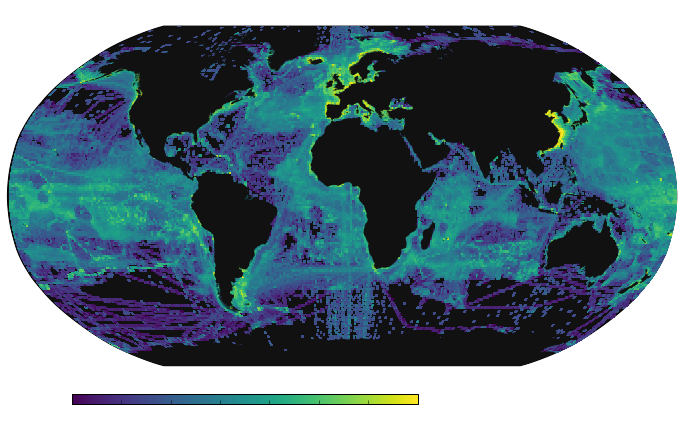

In [140]:
raster = fishing_grid_unfiltered
title="Density of Fishing Vessel in 2015, Unfiltered"
colorbar_label="Hours that Fishing Vessels were Present"
maximum=1000000
minimum=1
scale_type ="log"
cutoff=0
savefig=1 
png="fishingvesselhours_unfiltered.png"
continent_color = '#111111'
            
plt.clf()
plt.rcParams["figure.figsize"] = [12,7]
firstlat = 90-cutoff
lastlat = -90+cutoff
firstlon = -180
lastlon = 180
scale = cellsize
truncated_grid = raster[cutoff/cellsize:(180/cellsize)-cutoff/cellsize][:]

numlats = int((firstlat-lastlat)/scale+.5)
numlons = int((lastlon-firstlon)/scale+.5)
lat_boxes = np.linspace(lastlat,firstlat,num=numlats,endpoint=False)
lon_boxes = np.linspace(firstlon,lastlon,num=numlons,endpoint=False)
fig = plt.figure()
m = Basemap(llcrnrlat=lastlat, urcrnrlat=firstlat,
          llcrnrlon=lastlon, urcrnrlon=firstlon, lat_ts=0, projection='robin',resolution="h", lon_0=0)
m.drawmapboundary(fill_color='#111111')
# m.drawcoastlines(linewidth=.2)
m.fillcontinents(continent_color,lake_color=continent_color)#, lake_color, ax, zorder, alpha)
x = np.linspace(-180, 180, 360/cellsize)
y = np.linspace(lastlat, firstlat, (firstlat-lastlat)/cellsize)
x, y = np.meshgrid(x, y)
converted_x, converted_y = m(x, y)
from matplotlib import colors,colorbar
if scale_type == 'log':
    norm = colors.LogNorm(vmin=minimum, vmax=maximum)
else:
    norm = colors.Normalize(vmin=minimum, vmax=maximum)

m.pcolormesh(converted_x, converted_y, truncated_grid, norm=norm, vmin=minimum, vmax=maximum, cmap = plt.get_cmap('viridis'))
if title == None:
    title = "A Raster of Some Sorts"
plt.title(title, color = "#ffffff", fontsize=18)

ax = fig.add_axes([0.2, 0.1, 0.4, 0.02]) 
if scale_type == "log":
    lvls = np.logspace(np.log10(minimum),np.log10(maximum),num=8)
    cb = colorbar.ColorbarBase(ax,norm = norm, orientation='horizontal', ticks=lvls, cmap = plt.get_cmap('viridis'))
    the_labels = []
    for l in lvls:
        if l>=1:
            l = int(l)
        the_labels.append(l)
    cb.ax.set_xticklabels(the_labels, fontsize=10, color = "#ffffff")
else:
    cb = colorbar.ColorbarBase(ax,norm = norm, orientation='horizontal', cmap = plt.get_cmap('viridis'))

cb.set_label(colorbar_label,labelpad=-40, y=0.45, color = "#ffffff")
ax.text(1.7, -0.5, 'Data Source: Orbcomm\nMap by Global Fishing Watch',
        verticalalignment='bottom', horizontalalignment='right',
        transform=ax.transAxes, color='#ffffff', fontsize=6)
if savefig:
    plt.savefig(png,bbox_inches='tight',dpi=300,transparent=True,pad_inches=.1, facecolor="#000000")
plt.show()

In [142]:
gap_frequency_unfiltered = np.divide(gaps_nofilter,fishing_grid_unfiltered)

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: divide by zero encountered in divide
  if __name__ == '__main__':
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in divide
  if __name__ == '__main__':


/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in less_equal


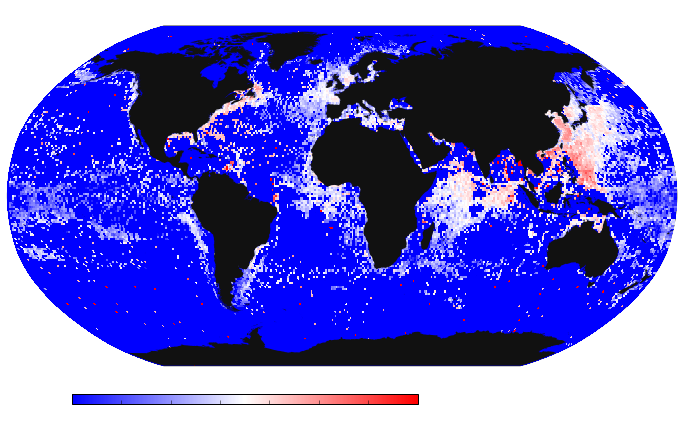

In [143]:
raster = np.copy(gap_frequency_unfiltered)
title="Number of 24+ Hour Gaps / Density of Fishing Vessels, No Filter"
colorbar_label="No. 24+ Hour Gaps / Total Hours Fishing Boats Were Present"
maximum=1
minimum=.0001
raster[raster<=minimum] = minimum
scale_type ="log"
cutoff=0
savefig=1 
png="24hrgaps_frequency_nofilter.png"
continent_color = '#111111'
            
plt.clf()
plt.rcParams["figure.figsize"] = [12,7]
firstlat = 90-cutoff
lastlat = -90+cutoff
firstlon = -180
lastlon = 180
scale = cellsize
truncated_grid = raster[cutoff/cellsize:(180/cellsize)-cutoff/cellsize][:]

numlats = int((firstlat-lastlat)/scale+.5)
numlons = int((lastlon-firstlon)/scale+.5)
lat_boxes = np.linspace(lastlat,firstlat,num=numlats,endpoint=False)
lon_boxes = np.linspace(firstlon,lastlon,num=numlons,endpoint=False)
fig = plt.figure()
m = Basemap(llcrnrlat=lastlat, urcrnrlat=firstlat,
          llcrnrlon=lastlon, urcrnrlon=firstlon, lat_ts=0, projection='robin',resolution="h", lon_0=0)
m.drawmapboundary(fill_color='#111111')
# m.drawcoastlines(linewidth=.2)
m.fillcontinents(continent_color,lake_color=continent_color)#, lake_color, ax, zorder, alpha)
x = np.linspace(-180, 180, 360/cellsize)
y = np.linspace(lastlat, firstlat, (firstlat-lastlat)/cellsize)
x, y = np.meshgrid(x, y)
converted_x, converted_y = m(x, y)
from matplotlib import colors,colorbar
if scale_type == 'log':
    norm = colors.LogNorm(vmin=minimum, vmax=maximum)
else:
    norm = colors.Normalize(vmin=minimum, vmax=maximum)

m.pcolormesh(converted_x, converted_y, truncated_grid, norm=norm, vmin=minimum, vmax=maximum, cmap = plt.get_cmap('bwr'))
if title == None:
    title = "A Raster of Some Sorts"
plt.title(title, color = "#FFFFFF", fontsize=18)

ax = fig.add_axes([0.2, 0.1, 0.4, 0.02]) 
if scale_type == "log":
    lvls = np.logspace(np.log10(minimum),np.log10(maximum),num=8)
    cb = colorbar.ColorbarBase(ax,norm = norm, orientation='horizontal', ticks=lvls, cmap = plt.get_cmap('bwr'))
    the_labels = []
    for l in lvls:
        if l>=1:
            l = int(l)
        else:
            l = round(l,2)
        the_labels.append(l)
    cb.ax.set_xticklabels(the_labels, fontsize=10, color = "#FFFFFF")
else:
    cb = colorbar.ColorbarBase(ax,norm = norm, orientation='horizontal', cmap = plt.get_cmap('bwr'))

cb.set_label(colorbar_label,labelpad=-40, y=0.45, color = "#FFFFFF")
ax.text(1.7, -0.5, 'Data Source: Orbcomm\nMap by Global Fishing Watch',
        verticalalignment='bottom', horizontalalignment='right',
        transform=ax.transAxes, color='#FFFFFF', fontsize=6)
if savefig:
    plt.savefig(png,bbox_inches='tight',dpi=300,transparent=True,pad_inches=.1, facecolor="#000000")
plt.show()

In [126]:
q = '''
SELECT 
  integer(FLOOR(lat)) lat_bin,
  integer(FLOOR(lon)) lon_bin,
  count(*) gap_starts
FROM [scratch_david_gapanalysis.2015_24hr_gaps_scored] 
where mmsi not in (412437961,412437962,412420502,412420503,412420576,412420574,412420789,412420871,
      900025357,900025393,413322650,414203586,412211196,412440255,412440256,412440257,412440258,412440259,
      412440261,150200162,412440077,412440078,412420805,412420421,412440377,412425706,412447093,412211691,
      412420276,412420917,411041815, 525018188, 412420276,412420561,533180156)
        AND seg_id NOT IN (
         SELECT seg_id
            FROM
              [scratch_david_seg_analysis.2015_segments_posonly] WHERE
              // High density areas
              (( (max_lat < 44.3
                    AND min_lat > -1.8
                    AND min_lon > 97.7
                    AND max_lon < 146.1)
                  OR (max_lat < 71
                    AND min_lat > 30
                    AND min_lon > -28
                    AND max_lon < 30))
                // In High density areas, ignore vessels with frequency of less than
                // half per hour, or point counts
                AND ( ( last_timestamp != first_timestamp
                    AND terrestrial_positions = point_count
                    AND (3600*1000000*point_count/(last_timestamp - first_timestamp)< .5
                      OR point_count <= 5))
                  OR (terrestrial_positions = point_count
                    AND last_timestamp = first_timestamp )
                  OR (point_count > 1
                    AND max_lat = min_lat
                    AND max_lon = min_lon) )) OR( NOT (max_lat < 44.3
                  AND min_lat > -1.8
                  AND min_lon > 97.7
                  AND max_lon < 146.1)
                OR (max_lat < 71
                  AND min_lat > 30
                  AND min_lon > -28
                  AND max_lon < 30))
              // In Low density areas, ignore vessels with frequency of less than
              // once per hour, or point counts under 20
              // and don't care if it is terrestrial or satellite
              AND ( ( last_timestamp != first_timestamp
                  //AND terrestrial_positions = point_count
                  AND (3600*1000000*point_count/(last_timestamp - first_timestamp)< 1
                    OR point_count <= 20))
                OR (last_timestamp = first_timestamp)
                OR (point_count > 1
                  AND max_lat = min_lat
                  AND max_lon = min_lon) )
              OR ((min_lon >= 0 // these are almost definitely noise
                  AND max_lon <= 0.109225)
                OR (min_lat >= 0
                  AND max_lat <= 0.109225)))
        and next_seg_id not in (   SELECT seg_id
            FROM
              [scratch_david_seg_analysis.2015_segments_posonly] WHERE
              // High density areas
              (( (max_lat < 44.3
                    AND min_lat > -1.8
                    AND min_lon > 97.7
                    AND max_lon < 146.1)
                  OR (max_lat < 71
                    AND min_lat > 30
                    AND min_lon > -28
                    AND max_lon < 30))
                // In High density areas, ignore vessels with frequency of less than
                // half per hour, or point counts
                AND ( ( last_timestamp != first_timestamp
                    AND terrestrial_positions = point_count
                    AND (3600*1000000*point_count/(last_timestamp - first_timestamp)< .5
                      OR point_count <= 5))
                  OR (terrestrial_positions = point_count
                    AND last_timestamp = first_timestamp )
                  OR (point_count > 1
                    AND max_lat = min_lat
                    AND max_lon = min_lon) )) OR( NOT (max_lat < 44.3
                  AND min_lat > -1.8
                  AND min_lon > 97.7
                  AND max_lon < 146.1)
                OR (max_lat < 71
                  AND min_lat > 30
                  AND min_lon > -28
                  AND max_lon < 30))
              // In Low density areas, ignore vessels with frequency of less than
              // once per hour, or point counts under 20
              // and don't care if it is terrestrial or satellite
              AND ( ( last_timestamp != first_timestamp
                  //AND terrestrial_positions = point_count
                  AND (3600*1000000*point_count/(last_timestamp - first_timestamp)< 1
                    OR point_count <= 20))
                OR (last_timestamp = first_timestamp)
                OR (point_count > 1
                  AND max_lat = min_lat
                  AND max_lon = min_lon) )
              OR ((min_lon >= 0 // these are almost definitely noise
                  AND max_lon <= 0.109225)
                OR (min_lat >= 0
                  AND max_lat <= 0.109225)))
group by lat_bin, lon_bin
'''

all_gaps = Query(q)

Waiting on bqjob_r2a43ccf63627b76f_00000154d9203d9e_13 ... (7s) Current status: DONE   
Query time: 11.1346321106 seconds.


In [127]:
# first calculate a raster of vessel locations from the query
cellsize = 1
num_lons = 360/cellsize
num_lats = 180/cellsize

gaps = np.zeros(shape=(num_lats,num_lons)) 
for row in all_gaps:
    lat = int(row[0])
    lon = int(row[1])
    if lat<90 and lat>-90 and lon>-180 and lon<180:
        lat_index = (lat+90)/(cellsize)
        lon_index = (lon+180)/(cellsize)
        gaps[lat_index][lon_index] += int(row[2]) # one vessel 

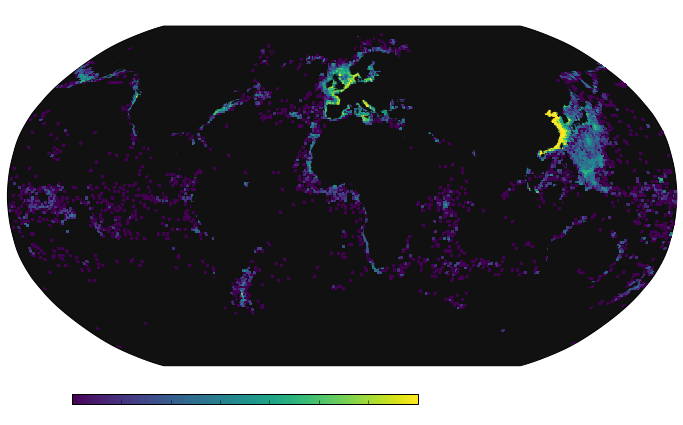

In [128]:
raster = gaps
title="Number of 24+ hour gaps in AIS in 2015"
colorbar_label="Gaps per 1 Degree Square"
maximum=500
minimum=1
scale_type ="log"
cutoff=0
savefig=1 
png="24hrgaps.png"
continent_color = '#111111'
            
plt.clf()
plt.rcParams["figure.figsize"] = [12,7]
firstlat = 90-cutoff
lastlat = -90+cutoff
firstlon = -180
lastlon = 180
scale = cellsize
truncated_grid = raster[cutoff/cellsize:(180/cellsize)-cutoff/cellsize][:]

numlats = int((firstlat-lastlat)/scale+.5)
numlons = int((lastlon-firstlon)/scale+.5)
lat_boxes = np.linspace(lastlat,firstlat,num=numlats,endpoint=False)
lon_boxes = np.linspace(firstlon,lastlon,num=numlons,endpoint=False)
fig = plt.figure()
m = Basemap(llcrnrlat=lastlat, urcrnrlat=firstlat,
          llcrnrlon=lastlon, urcrnrlon=firstlon, lat_ts=0, projection='robin',resolution="h", lon_0=0)
m.drawmapboundary(fill_color='#111111')
# m.drawcoastlines(linewidth=.2)
m.fillcontinents(continent_color,lake_color=continent_color)#, lake_color, ax, zorder, alpha)
x = np.linspace(-180, 180, 360/cellsize)
y = np.linspace(lastlat, firstlat, (firstlat-lastlat)/cellsize)
x, y = np.meshgrid(x, y)
converted_x, converted_y = m(x, y)
from matplotlib import colors,colorbar
if scale_type == 'log':
    norm = colors.LogNorm(vmin=minimum, vmax=maximum)
else:
    norm = colors.Normalize(vmin=minimum, vmax=maximum)

m.pcolormesh(converted_x, converted_y, truncated_grid, norm=norm, vmin=minimum, vmax=maximum, cmap = plt.get_cmap('viridis'))
if title == None:
    title = "A Raster of Some Sorts"
plt.title(title, color = "#FFFFFF", fontsize=18)

ax = fig.add_axes([0.2, 0.1, 0.4, 0.02]) 
if scale_type == "log":
    lvls = np.logspace(np.log10(minimum),np.log10(maximum),num=8)
    cb = colorbar.ColorbarBase(ax,norm = norm, orientation='horizontal', ticks=lvls, cmap = plt.get_cmap('viridis'))
    the_labels = []
    for l in lvls:
        if l>=1:
            l = int(l)
        the_labels.append(l)
    cb.ax.set_xticklabels(the_labels, fontsize=10, color = "#FFFFFF")
else:
    cb = colorbar.ColorbarBase(ax,norm = norm, orientation='horizontal', cmap = plt.get_cmap('viridis'))

cb.set_label(colorbar_label,labelpad=-40, y=0.45, color = "#FFFFFF")
ax.text(1.7, -0.5, 'Data Source: Orbcomm\nMap by Global Fishing Watch',
        verticalalignment='bottom', horizontalalignment='right',
        transform=ax.transAxes, color='#FFFFFF', fontsize=6)
if savefig:
    plt.savefig(png,bbox_inches='tight',dpi=300,transparent=True,pad_inches=.1, facecolor="#000000")
plt.show()

In [23]:
q = '''    
    SELECT 
    integer(floor(lat)) lat_bin,
    integer(floor(lon)) lon_bin,
    (sum(last_hours) + sum(next_hours))/2 vessel_hours,
    avg(distance_from_shore) distance_from_shore
    FROM [scratch_global_fishing_raster.2015_with_score_and_hours]
    where 
      lat > -80 and lat < 90 and lat != 0 
        and not (lon > -7.63 and lat>7.49 and lon < 30.76 and lat < 29.57)
        and not (lon > -7.63 and lat>29.34 and lon < 11.21 and lat < 32.93)
        and not (lon > -0.66 and lat>32.79 and lon < 9.8 and lat < 35.41)
        and not (lon > 13.16 and lat>-3.07 and lon < 29.9 and lat < 6.49)
        and not (lon > -121.0 and lat>47.7 and lon < -109.5 and lat < 52.2)
        and not (lon > 33.09 and lat>54.29 and lon < 42.54 and lat < 59.87)
        and not (lon > 56.6 and lat>41.6 and lon < 116.9 and lat < 65.4)
        and not (lon > 56.6 and lat>29.61 and lon < 77.17 and lat < 45.27)
        and not (lon > 103.29 and lat>11.63 and lon < 107.47 and lat < 15.22)
        and not (lon > 94.86 and lat>19.41 and lon < 105.12 and lat < 24.63)
        and not (lon > 113.77 and lat>-0.88 and lon < 116.88 and lat < 3.44)
        and not (lon > 19.24 and lat>-31.25 and lon < 28.57 and lat < 3.31)
        and not (lon > 88.2 and lat>60.8 and lon < 149.46 and lat < 70.45)
        and not (lon > 100.5 and lat>43.9 and lon < 132.7 and lat < 70.2)
        and not (lon > 38.01 and lat>26.49 and lon < 47.15 and lat < 34.69)
        and not (lon > 20.57 and lat>19.06 and lon < 24.43 and lat < 31.52)
        and not (lon > 11.84 and lat>50.32 and lon < 17.12 and lat < 51.82)
        and not (lon > -0.9 and lat>41.77 and lon < 1.87 and lat < 43.68)
        and not (lon > 8.72 and lat>44.73 and lon < 10.9 and lat < 48.67)
        and not (lon > -51.33 and lat>-22.53 and lon < -44.17 and lat < -18.77)
        and not (lon > -86.0394 and lat>41.8205 and lon < -84.1388 and lat < 44.2845)
        and not (lon > -52.46 and lat>-28.91 and lon < -50.16 and lat < -26.02)

      //divide into 4 parts because a single query is too big for this api
      and lon > -180 and lon < 180
      and  mmsi IN (
        SELECT
          mmsi
        FROM
          [scratch_global_fishing_raster.2015_mmsi_pointcounts]
        WHERE
          num_points >= 1000)
      and mmsi not in (412437961,412437962,412420502,412420503,412420576,412420574,412420789,412420871,
      900025357,900025393,413322650,414203586,412211196,412440255,412440256,412440257,412440258,412440259,
      412440261,150200162,412440077,412440078,412420805,412420421,412440377,412425706,412447093,412211691,
      412420276,412420917,411041815, 525018188, 412420276,412420561,533180156)
      and mmsi in (select mmsi from [scratch_bjorn.2015_combined_fishing])
         AND seg_id NOT IN (
         SELECT seg_id
            FROM
              [scratch_david_seg_analysis.2015_segments_posonly] WHERE
              // High density areas
              (( (max_lat < 44.3
                    AND min_lat > -1.8
                    AND min_lon > 97.7
                    AND max_lon < 146.1)
                  OR (max_lat < 71
                    AND min_lat > 30
                    AND min_lon > -28
                    AND max_lon < 30))
                // In High density areas, ignore vessels with frequency of less than
                // half per hour, or point counts
                AND ( ( last_timestamp != first_timestamp
                    AND terrestrial_positions = point_count
                    AND (3600*1000000*point_count/(last_timestamp - first_timestamp)< .5
                      OR point_count <= 5))
                  OR (terrestrial_positions = point_count
                    AND last_timestamp = first_timestamp )
                  OR (point_count > 1
                    AND max_lat = min_lat
                    AND max_lon = min_lon) )) OR( NOT (max_lat < 44.3
                  AND min_lat > -1.8
                  AND min_lon > 97.7
                  AND max_lon < 146.1)
                OR (max_lat < 71
                  AND min_lat > 30
                  AND min_lon > -28
                  AND max_lon < 30))
              // In Low density areas, ignore vessels with frequency of less than
              // once per hour, or point counts under 20
              // and don't care if it is terrestrial or satellite
              AND ( ( last_timestamp != first_timestamp
                  //AND terrestrial_positions = point_count
                  AND (3600*1000000*point_count/(last_timestamp - first_timestamp)< 1
                    OR point_count <= 20))
                OR (last_timestamp = first_timestamp)
                OR (point_count > 1
                  AND max_lat = min_lat
                  AND max_lon = min_lon) )
              OR ((min_lon >= 0 // these are almost definitely noise
                  AND max_lon <= 0.109225)
                OR (min_lat >= 0
                  AND max_lat <= 0.109225))
      )
    group by lat_bin, lon_bin
    '''
fishing_vessel_density = Query(q)

Waiting on bqjob_r2d2274b9a8c1bb0f_00000154cae3ea1c_6 ... (35s) Current status: DONE   
Query time: 40.7758760452 seconds.


In [27]:
# first calculate a raster of vessel locations from the query
cellsize = 1
num_lons = 360/cellsize
num_lats = 180/cellsize

fishing_grid = np.zeros(shape=(num_lats,num_lons)) 
for row in fishing_vessel_density:
    lat = int(row[0])
    lon = int(row[1])
    if lat<90 and lat>-90 and lon>-180 and lon<180:
        lat_index = (lat+90)/(cellsize)
        lon_index = (lon+180)/(cellsize)
        fishing_grid[lat_index][lon_index] += float(row[2]) # one vessel 

In [45]:
gaps.sum()/fishing_grid.sum()


0.0056754105931794913

In [129]:
fishing_grid.max()

gap_frequency = np.divide(gaps,fishing_grid)
#fishing_grid[fishing_grid == 0] = .1

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in divide
  app.launch_new_instance()
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in divide
  app.launch_new_instance()


In [130]:
gap_frequency.max()

nan

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in less_equal


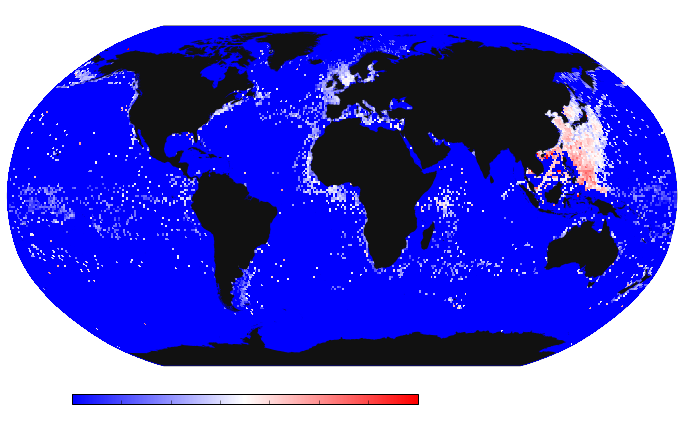

In [133]:
raster = np.copy(gap_frequency)
title="Number of 24+ Hour Gaps / Density of Fishing Vessels"
colorbar_label="No. 24+ Hour Gaps / Total Hours Fishing Boats Were Present"
maximum=1
minimum=.0001
raster[raster<=minimum] = minimum
scale_type ="log"
cutoff=0
savefig=1 
png="24hrgaps_frequency3.png"
continent_color = '#111111'
            
plt.clf()
plt.rcParams["figure.figsize"] = [12,7]
firstlat = 90-cutoff
lastlat = -90+cutoff
firstlon = -180
lastlon = 180
scale = cellsize
truncated_grid = raster[cutoff/cellsize:(180/cellsize)-cutoff/cellsize][:]

numlats = int((firstlat-lastlat)/scale+.5)
numlons = int((lastlon-firstlon)/scale+.5)
lat_boxes = np.linspace(lastlat,firstlat,num=numlats,endpoint=False)
lon_boxes = np.linspace(firstlon,lastlon,num=numlons,endpoint=False)
fig = plt.figure()
m = Basemap(llcrnrlat=lastlat, urcrnrlat=firstlat,
          llcrnrlon=lastlon, urcrnrlon=firstlon, lat_ts=0, projection='robin',resolution="h", lon_0=0)
m.drawmapboundary(fill_color='#111111')
# m.drawcoastlines(linewidth=.2)
m.fillcontinents(continent_color,lake_color=continent_color)#, lake_color, ax, zorder, alpha)
x = np.linspace(-180, 180, 360/cellsize)
y = np.linspace(lastlat, firstlat, (firstlat-lastlat)/cellsize)
x, y = np.meshgrid(x, y)
converted_x, converted_y = m(x, y)
from matplotlib import colors,colorbar
if scale_type == 'log':
    norm = colors.LogNorm(vmin=minimum, vmax=maximum)
else:
    norm = colors.Normalize(vmin=minimum, vmax=maximum)

m.pcolormesh(converted_x, converted_y, truncated_grid, norm=norm, vmin=minimum, vmax=maximum, cmap = plt.get_cmap('bwr'))
if title == None:
    title = "A Raster of Some Sorts"
plt.title(title, color = "#FFFFFF", fontsize=18)

ax = fig.add_axes([0.2, 0.1, 0.4, 0.02]) 
if scale_type == "log":
    lvls = np.logspace(np.log10(minimum),np.log10(maximum),num=8)
    cb = colorbar.ColorbarBase(ax,norm = norm, orientation='horizontal', ticks=lvls, cmap = plt.get_cmap('bwr'))
    the_labels = []
    for l in lvls:
        if l>=1:
            l = int(l)
        else:
            l = round(l,2)
        the_labels.append(l)
    cb.ax.set_xticklabels(the_labels, fontsize=10, color = "#FFFFFF")
else:
    cb = colorbar.ColorbarBase(ax,norm = norm, orientation='horizontal', cmap = plt.get_cmap('bwr'))

cb.set_label(colorbar_label,labelpad=-40, y=0.45, color = "#FFFFFF")
ax.text(1.7, -0.5, 'Data Source: Orbcomm\nMap by Global Fishing Watch',
        verticalalignment='bottom', horizontalalignment='right',
        transform=ax.transAxes, color='#FFFFFF', fontsize=6)
if savefig:
    plt.savefig(png,bbox_inches='tight',dpi=300,transparent=True,pad_inches=.1, facecolor="#000000")
plt.show()

In [34]:
fishing_grid.max()

# fishing_grid[fishing_grid <] = .1
# gap_frequency2 = np.divide(gaps,fishing_grid)


4325832.3847222403

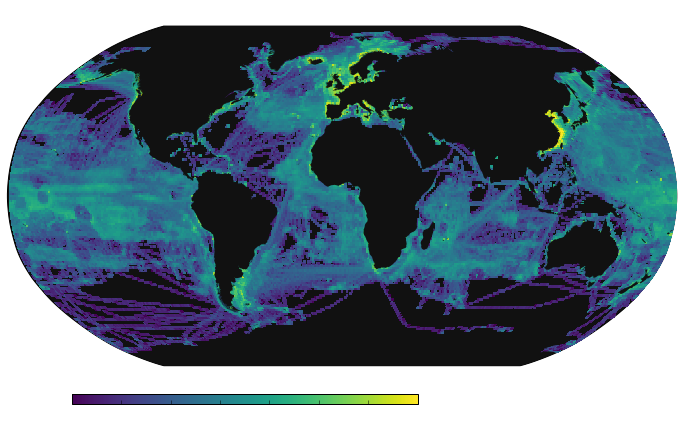

In [98]:
raster = fishing_grid
title="Density of Fishing Vessel in 2015"
colorbar_label="Hours that Fishing Vessels were Present"
maximum=1000000
minimum=1
scale_type ="log"
cutoff=0
savefig=1 
png="fishingvesselhours.png"
continent_color = '#111111'
            
plt.clf()
plt.rcParams["figure.figsize"] = [12,7]
firstlat = 90-cutoff
lastlat = -90+cutoff
firstlon = -180
lastlon = 180
scale = cellsize
truncated_grid = raster[cutoff/cellsize:(180/cellsize)-cutoff/cellsize][:]

numlats = int((firstlat-lastlat)/scale+.5)
numlons = int((lastlon-firstlon)/scale+.5)
lat_boxes = np.linspace(lastlat,firstlat,num=numlats,endpoint=False)
lon_boxes = np.linspace(firstlon,lastlon,num=numlons,endpoint=False)
fig = plt.figure()
m = Basemap(llcrnrlat=lastlat, urcrnrlat=firstlat,
          llcrnrlon=lastlon, urcrnrlon=firstlon, lat_ts=0, projection='robin',resolution="h", lon_0=0)
m.drawmapboundary(fill_color='#111111')
# m.drawcoastlines(linewidth=.2)
m.fillcontinents(continent_color,lake_color=continent_color)#, lake_color, ax, zorder, alpha)
x = np.linspace(-180, 180, 360/cellsize)
y = np.linspace(lastlat, firstlat, (firstlat-lastlat)/cellsize)
x, y = np.meshgrid(x, y)
converted_x, converted_y = m(x, y)
from matplotlib import colors,colorbar
if scale_type == 'log':
    norm = colors.LogNorm(vmin=minimum, vmax=maximum)
else:
    norm = colors.Normalize(vmin=minimum, vmax=maximum)

m.pcolormesh(converted_x, converted_y, truncated_grid, norm=norm, vmin=minimum, vmax=maximum, cmap = plt.get_cmap('viridis'))
if title == None:
    title = "A Raster of Some Sorts"
plt.title(title, color = "#ffffff", fontsize=18)

ax = fig.add_axes([0.2, 0.1, 0.4, 0.02]) 
if scale_type == "log":
    lvls = np.logspace(np.log10(minimum),np.log10(maximum),num=8)
    cb = colorbar.ColorbarBase(ax,norm = norm, orientation='horizontal', ticks=lvls, cmap = plt.get_cmap('viridis'))
    the_labels = []
    for l in lvls:
        if l>=1:
            l = int(l)
        the_labels.append(l)
    cb.ax.set_xticklabels(the_labels, fontsize=10, color = "#ffffff")
else:
    cb = colorbar.ColorbarBase(ax,norm = norm, orientation='horizontal', cmap = plt.get_cmap('viridis'))

cb.set_label(colorbar_label,labelpad=-40, y=0.45, color = "#ffffff")
ax.text(1.7, -0.5, 'Data Source: Orbcomm\nMap by Global Fishing Watch',
        verticalalignment='bottom', horizontalalignment='right',
        transform=ax.transAxes, color='#ffffff', fontsize=6)
if savefig:
    plt.savefig(png,bbox_inches='tight',dpi=300,transparent=True,pad_inches=.1, facecolor="#000000")
plt.show()

In [103]:
prob_of_gap = gaps.sum()/(fishing_grid.sum()/24)
prob_of_gap



0.1362098542363078

In [104]:
import scipy
prob_array = np.zeros((180,360))
for i in range(180):
    for j in range(360):
        prob_array[i][j] = scipy.stats.binom.pmf(int(gaps[i][j]),int(fishing_grid[i][j]/24),prob_of_gap)
#         if int(total[i][j])>0: print prob_array[i][j], scipy.stats.binom.cdf(int(a[i][j]),int(total[i][j]),prob_of_gap), int(a[i][j]),int(total[i][j])
#         if scipy.stats.binom.cdf(int(a[i][j]),int(total[i][j]),prob_of_gap, loc=0) > .5 and int(total[i][j])>0:
#             prob_array[i][j] =  1 - prob_array[i][j]
#             print "doing this!"
#         if total[i][j]==0:
#             prob_array[i][j] = .5

4.0791986576672096e-318

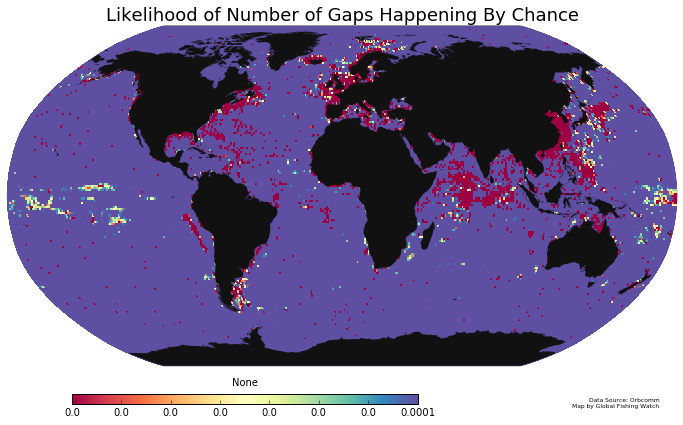

In [108]:
raster = np.copy(prob_array)


title="Likelihood of Number of Gaps Happening By Chance"
colorbar_label=None
maximum=.0001
minimum=.000000000001

raster[raster<=minimum]=minimum
scale_type ="log"
cutoff=0
savefig=1 
png="gaplikelihood.png"
continent_color = '#111111'
            
plt.clf()
plt.rcParams["figure.figsize"] = [12,7]
firstlat = 90-cutoff
lastlat = -90+cutoff
firstlon = -180
lastlon = 180
scale = cellsize
truncated_grid = raster[cutoff/cellsize:(180/cellsize)-cutoff/cellsize][:]

numlats = int((firstlat-lastlat)/scale+.5)
numlons = int((lastlon-firstlon)/scale+.5)
lat_boxes = np.linspace(lastlat,firstlat,num=numlats,endpoint=False)
lon_boxes = np.linspace(firstlon,lastlon,num=numlons,endpoint=False)
fig = plt.figure()
m = Basemap(llcrnrlat=lastlat, urcrnrlat=firstlat,
          llcrnrlon=lastlon, urcrnrlon=firstlon, lat_ts=0, projection='robin',resolution="h", lon_0=0)
m.drawmapboundary(fill_color='#111111')
# m.drawcoastlines(linewidth=.2)
m.fillcontinents(continent_color,lake_color=continent_color)#, lake_color, ax, zorder, alpha)
x = np.linspace(-180, 180, 360/cellsize)
y = np.linspace(lastlat, firstlat, (firstlat-lastlat)/cellsize)
x, y = np.meshgrid(x, y)
converted_x, converted_y = m(x, y)
from matplotlib import colors,colorbar
if scale_type == 'log':
    norm = colors.LogNorm(vmin=minimum, vmax=maximum)
else:
    norm = colors.Normalize(vmin=minimum, vmax=maximum)

m.pcolormesh(converted_x, converted_y, truncated_grid, norm=norm, vmin=minimum, vmax=maximum, cmap = plt.get_cmap('Spectral'))
if title == None:
    title = "A Raster of Some Sorts"
plt.title(title, color = "#000000", fontsize=18)

ax = fig.add_axes([0.2, 0.1, 0.4, 0.02]) 
if scale_type == "log":
    lvls = np.logspace(np.log10(minimum),np.log10(maximum),num=8)
    cb = colorbar.ColorbarBase(ax,norm = norm, orientation='horizontal', ticks=lvls, cmap = plt.get_cmap('Spectral'))
    the_labels = []
    for l in lvls:
        if l>=1:
            l = int(l)
        else:
            l = round(l,4)
        the_labels.append(l)
    cb.ax.set_xticklabels(the_labels, fontsize=10, color = "#000000")
else:
    cb = colorbar.ColorbarBase(ax,norm = norm, orientation='horizontal', cmap = plt.get_cmap('Spectral'))

cb.set_label(colorbar_label,labelpad=-40, y=0.45, color = "#000000")
ax.text(1.7, -0.5, 'Data Source: Orbcomm\nMap by Global Fishing Watch',
        verticalalignment='bottom', horizontalalignment='right',
        transform=ax.transAxes, color='#000000', fontsize=6)
if savefig:
    plt.savefig(png,bbox_inches='tight',dpi=300,transparent=True,pad_inches=.1, facecolor="#000000")
plt.show()

In [86]:
gap_frequency_2 = np.copy(gap_frequency)
gap_frequency_2[gap_frequency_2<prob_of_gap] = 0
gap_frequency_2[gap_frequency_2>=prob_of_gap] = 1

prob_array_2 = np.multiply(gap_frequency_2,prob_array)


/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in less
  from ipykernel import kernelapp as app
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in greater_equal
  app.launch_new_instance()


In [87]:
scipy.stats.binom.pmf(1,10,.1)

0.38742048900000048

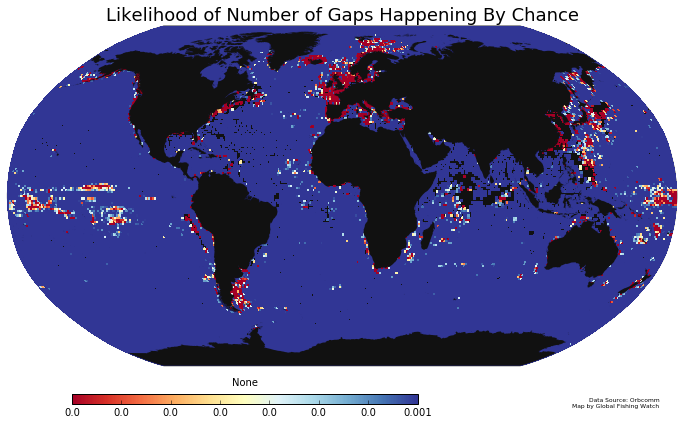

In [109]:
raster = prob_array
title="Likelihood of Number of Gaps Happening By Chance"
colorbar_label=None
maximum=.001
minimum=0.00000001
scale_type ="log"
cutoff=0
savefig=1 
png="gaplikelihood2.png"
continent_color = '#111111'
            
plt.clf()
plt.rcParams["figure.figsize"] = [12,7]
firstlat = 90-cutoff
lastlat = -90+cutoff
firstlon = -180
lastlon = 180
scale = cellsize
truncated_grid = raster[cutoff/cellsize:(180/cellsize)-cutoff/cellsize][:]

numlats = int((firstlat-lastlat)/scale+.5)
numlons = int((lastlon-firstlon)/scale+.5)
lat_boxes = np.linspace(lastlat,firstlat,num=numlats,endpoint=False)
lon_boxes = np.linspace(firstlon,lastlon,num=numlons,endpoint=False)
fig = plt.figure()
m = Basemap(llcrnrlat=lastlat, urcrnrlat=firstlat,
          llcrnrlon=lastlon, urcrnrlon=firstlon, lat_ts=0, projection='robin',resolution="h", lon_0=0)
m.drawmapboundary(fill_color='#111111')
# m.drawcoastlines(linewidth=.2)
m.fillcontinents(continent_color,lake_color=continent_color)#, lake_color, ax, zorder, alpha)
x = np.linspace(-180, 180, 360/cellsize)
y = np.linspace(lastlat, firstlat, (firstlat-lastlat)/cellsize)
x, y = np.meshgrid(x, y)
converted_x, converted_y = m(x, y)
from matplotlib import colors,colorbar
if scale_type == 'log':
    norm = colors.LogNorm(vmin=minimum, vmax=maximum)
else:
    norm = colors.Normalize(vmin=minimum, vmax=maximum)

m.pcolormesh(converted_x, converted_y, truncated_grid, norm=norm, vmin=minimum, vmax=maximum, cmap = plt.get_cmap('RdYlBu'))
if title == None:
    title = "A Raster of Some Sorts"
plt.title(title, color = "#000000", fontsize=18)

ax = fig.add_axes([0.2, 0.1, 0.4, 0.02]) 
if scale_type == "log":
    lvls = np.logspace(np.log10(minimum),np.log10(maximum),num=8)
    cb = colorbar.ColorbarBase(ax,norm = norm, orientation='horizontal', ticks=lvls, cmap = plt.get_cmap('RdYlBu'))
    the_labels = []
    for l in lvls:
        if l>=1:
            l = int(l)
        else:
            l = round(l,3)
        the_labels.append(l)
    cb.ax.set_xticklabels(the_labels, fontsize=10, color = "#000000")
else:
    cb = colorbar.ColorbarBase(ax,norm = norm, orientation='horizontal', cmap = plt.get_cmap('RdYlBu'))

cb.set_label(colorbar_label,labelpad=-40, y=0.45, color = "#000000")
ax.text(1.7, -0.5, 'Data Source: Orbcomm\nMap by Global Fishing Watch',
        verticalalignment='bottom', horizontalalignment='right',
        transform=ax.transAxes, color='#000000', fontsize=6)
if savefig:
    plt.savefig(png,bbox_inches='tight',dpi=300,transparent=True,pad_inches=.1, facecolor="#000000")
plt.show()